# Fine-tuning BLIP on a captioning task

In this notebook, we will see how to fine-tune BLIP on a captioning task.  
Specifically, the task require us to provide a description for images of doodle characters that look something like this:

<img src="https://datasets-server.huggingface.co/assets/julianmoraes/doodles-captions-manual/--/julianmoraes--doodles-captions-manual/train/1/image/image.jpg" alt="Doodle sample" style="width: 200px;"/>

While their description is something like this:  
_"a holographic beard character with a gradient 2 head and white bucket cap hair wearing a purple sweater with satchel, grey background"_


BLIP is a strong foundational models that is able to tackle a diverse set of VL tasks in zero-shot settings.  
We will see that the base BLIP model is able to provide coherent captions for our doodles.  
However, fine-tuning it enables us to obtain near-perfect looking captions that accurately describe the drawings.  

This process can be applied on any image captionig task, provided that we have a training dataset with correct captions.


### How and why should I apply this?

What is the point of fine-tuning a zero-shot capable model?  
I will for sure lose some of its generalization capabilities!

Yes, its _very_ true, and if you need a general purpose captioner, that's the way to go, BUT...  
A few use cases where this may be useful:
- I need to train a captioner model on a problem with peculiar/uncommon images and/or descriptions, and I don't have many data available
    - Starting from a good foundational model allows us to transfer the language knowledge of the generator more easily on our task
- I need to train a very specific captioner model. The captioner needs to produce near perfect captions on a rather limited set of input images, I don't really care that the model loses some generalization. I want to solve my problem as best as I can.
- I have a specific captioning problem to solve, and BLIP provides decent results. I just want to nerd out and see if and how I can improve the performances on _my_ problem.

    
### What can you learn from the notebook

The notebook shows how to:
1. Use an available Huggingface `Dataset`
    1. Define appropriate data transformation functions for images and texts to provide correct inputs to a BLIP model 
1. Apply and evaluate a BLIP model on captioning in zero-shot setting using Huggingface Transformers
1. Fine-tune BLIP for captioning (i.e., conditional generation)
    1. using the Huggingface `Trainer` API 
    1. on a Huggingface Dataset
1. Evaluate the fine-tuned model on the task (i.e., generate captions given input images).

### What's not in notebook

In this notebook, you will not find:
1. How to load your own data in the Huggingface Dataset format
1. A hand-crafted training loop
1. Caption generation with text prompts


## Table of Contents
* [Requirements](#requirements)
* [The doodles-caption Dataset](#dataset)
* [Zero-shot BLIP](#zeroshot)
* [Fine-tuning BLIP on image captioning](#finetune)
    * [From data to inputs](#data-transform)
        * [Data transformations and data collator](#transform-and-collate)
    * [Training with Trainer](#training)
    * [Evaluation after training](#evaluation)

## Requirements<a class="anchor" id="requirements"></a>

First, we need to install a few Python libraries to get the job done.  
Most of the notebook is based on Huggingface Transformers and Dataset, but we also need some PyTorch and Torchvision based code to work with images.  
We'll also use SciKit-Learn for evaluating the classification results.

To install the libraries, a simple `pip install` follwoed by the name of the required libraries will be sufficient if you're installing from CLI.

If you're installing from inside the notebook, I suggest to use `sys.executable` to call the correct python executable, like this (don't forget the ! character at the beginning of the line):

In [1]:
import sys

!{sys.executable} -m pip install transformers datasets torch torchvision scikit-learn matplotlib

Then, we can import the required modules and specific classes for each.

Here we also set the PyTorch `device` to `"cuda"` if we have one or more GPUs available so we can use it for training and inference. If we have Cuda available, we will print the info on our GPUs.

Finally, we also set a random seed to get reproducible results.

In [2]:
from datasets import load_dataset
from IPython.display import Image 
import PIL
import requests
import matplotlib.pyplot as plt

from transformers import (
    Trainer,
    TrainingArguments,
    AutoProcessor, 
    BlipForConditionalGeneration,
    set_seed
)

import torch
import torch.nn.functional as F
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.functional as trans

import numpy as np

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.cuda.empty_cache()

set_seed(23)

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## The doodles captions dataset<a class="anchor" id="dataset"></a>

For our experiment we will use a dataset containing doodles and their description.

The dataset is avali

The dataset features 15 different classes of Human Activities.
The dataset contains about 12k+ labelled images including the test images.
Each image has only one human activity category.

A small caveat: since the dataset was originally part of a [Kaggle competition](https://dphi.tech/challenges/data-sprint-76-human-activity-recognition/233/data), the test set is unlabelled.  
We will have to make do with the training set, and split it into train and validation. 

First, we load the dataset [from Huggingface](https://huggingface.co/datasets/Bingsu/Human_Action_Recognition). The dataset is quite small (~100MB), so it can fit easily in the memory.

In [3]:
dataset = load_dataset(
            "julianmoraes/doodles-captions-manual",
            keep_in_memory=False
        ) 

dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

Found cached dataset parquet (/home/bondielli/.cache/huggingface/datasets/julianmoraes___parquet/julianmoraes--doodles-captions-manual-82576e5d7ca8a120/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.70it/s]
Loading cached split indices for dataset at /home/bondielli/.cache/huggingface/datasets/julianmoraes___parquet/julianmoraes--doodles-captions-manual-82576e5d7ca8a120/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-a7178622f3ba9d01.arrow and /home/bondielli/.cache/huggingface/datasets/julianmoraes___parquet/julianmoraes--doodles-captions-manual-82576e5d7ca8a120/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-bb7db9caa619c0b6.arrow


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 200
    })
})

### Dataset samples

Let's take a look at a few of the dataset's samples

In [4]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(5,5))
    fig.tight_layout()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(np.ceil(n_images/float(cols))), cols, n + 1)
        #a.set_title(title, wrap = True, loc = "left")
        a.text(0.5, 1, title, fontsize = 16,
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=a.transAxes,
               wrap = True,
               bbox=dict(facecolor='white', alpha=0.9,  boxstyle='round'))
        plt.axis('off')
        plt.imshow(image)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

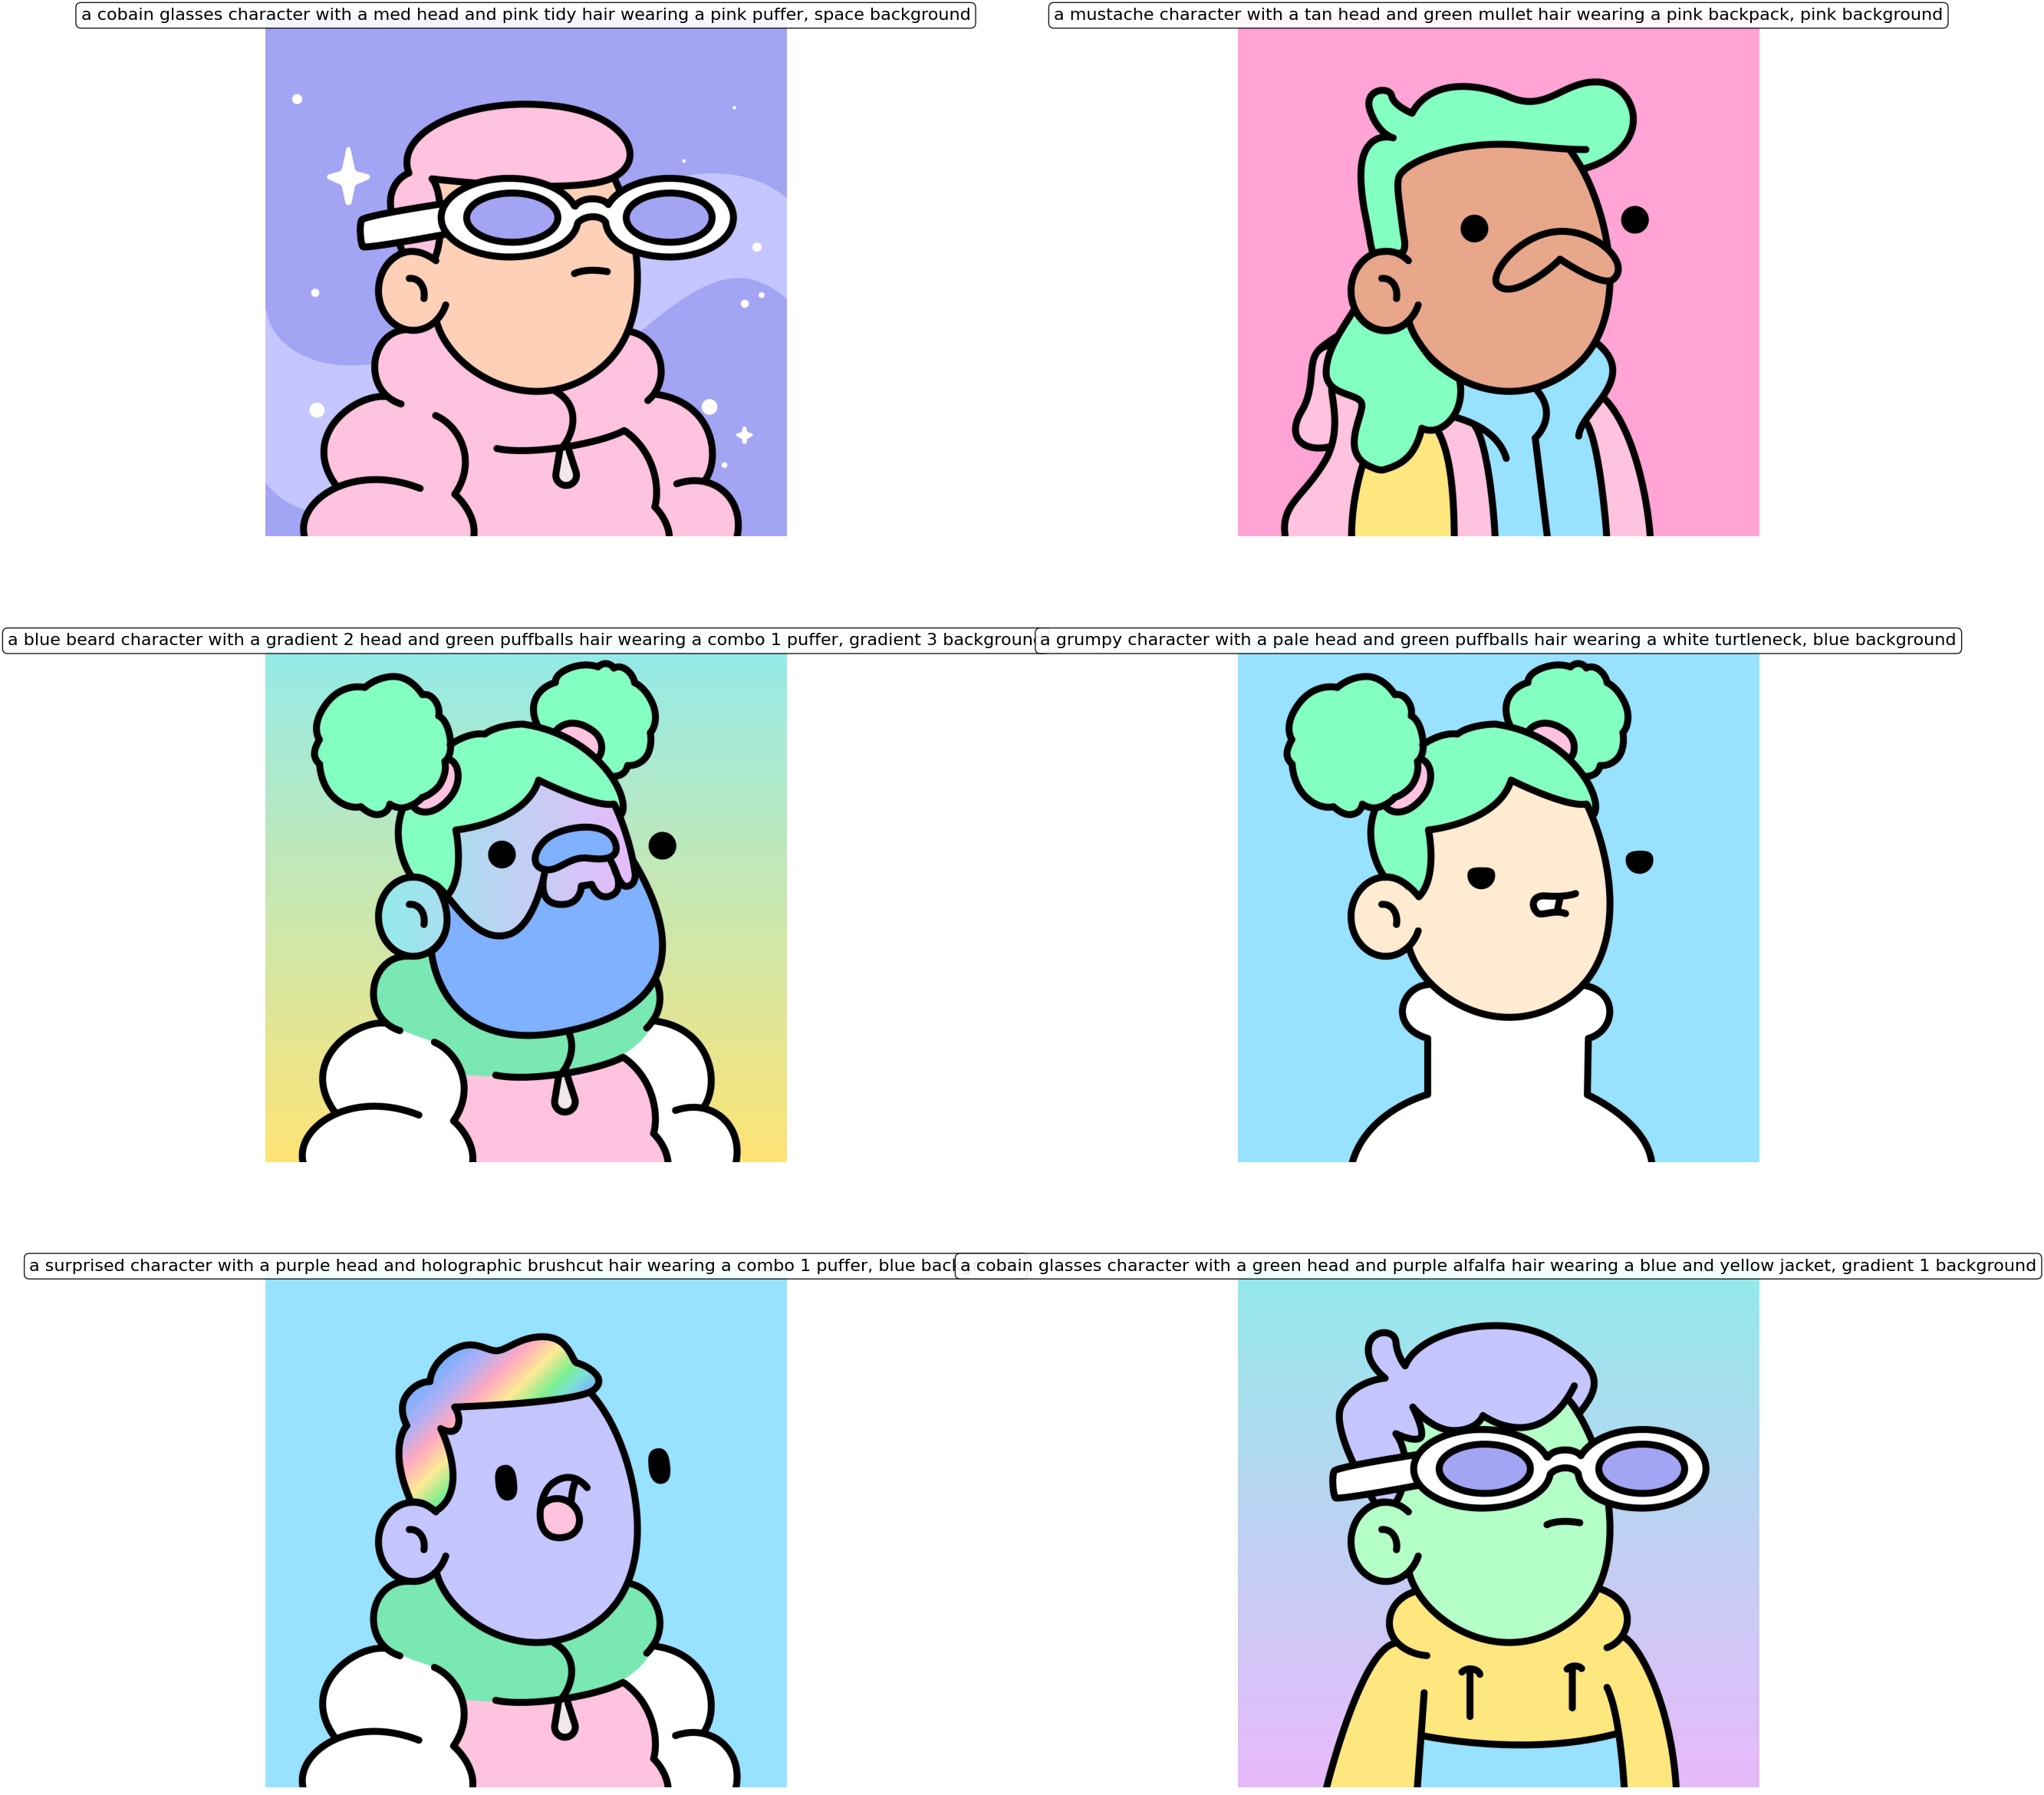

In [5]:
sample = dataset['train'][:6]

show_images(sample['image'], cols = 2, titles = sample['text'])

## Zero-shot BLIP<a class="anchor" id="zeroshot"></a>

Now we load the base [BLIP model from Huggingface](https://huggingface.co/Salesforce/blip-image-captioning-base), and apply it to our captioning task.  
We know that BLIP is trained with a mixture of training objectives on image-caption pairs.  
Note that we load the model fo captioning (i.e., `BlipForConditionalGeneration`)

Let's go step by step. First we load the model and the processor (it converts images and text in a format that the model accepts, similar to a tokenizer for LMs).

In [6]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
config = model.config

Let's try using BLIP on one image.

We extract the image from the test set, then:
- We use the processor to return the proper inputs to the model (i.e., the `pixel_values`)
- We pass the inputs to the `model.generate()` function
- We use the processor to decode the generated tokens into a real caption

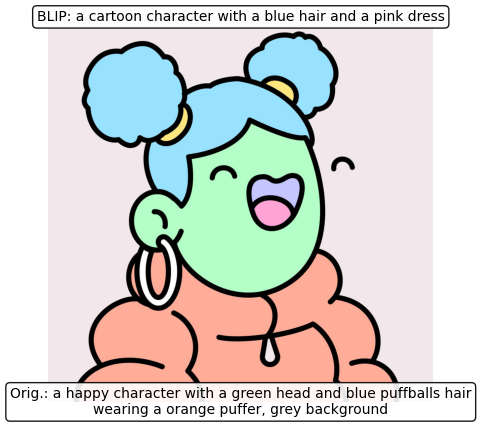

In [7]:
image = dataset['test'][1]

#prompt = "a picture"
prompt = None

inputs = processor(images=image['image'], return_tensors="pt")
pixel_values = inputs.pixel_values

generated_ids = model.generate(**inputs, max_new_tokens = 100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(image['image'])

ax.text(0.5, 1, "BLIP: "+generated_caption,
               horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,
               bbox=dict(facecolor='white', alpha=0.9,  boxstyle='round'))

ax.text(0.5, 0, "Orig.: "+image['text'],
               horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,
               wrap = True,
               bbox=dict(facecolor='white', alpha=0.9,  boxstyle='round'))
plt.axis('off')
plt.show()

Not bad, but we can make it better by fine tuning the model on our captions.

## Fine-tuning BLIP on image captioning<a class="anchor" id="finetune"></a>

Now we dive into how to fine-tune BLIP to provide captions for our doodles.

The training will carried out via the `Trainer` API. It will take care of the training loop for us, and we will initialize it only with:
- Training arguments: the hyperparameters of the model (as a separate object)
- training set: the split of the HF dataset we will use for training
- validation set: the split of the HF dataset will use for validation
- a data collator: a function to collate images and text data into batches

We also need a few more functions to transform the data into the correct inputs for the model.

We will directly fine-tune the BLIP model and save it on disk once it's been trained.

### From data to inputs<a class="anchor" id="data-transform"></a>

We need to prepare our data to be fed as input to the model.  

Our training examples are images and captions.


#### Data transformations and data collator<a class="anchor" id="transform-and-collate"></a>

The `Trainer` directly feeds on the `Dataset`via a **data collator**.  
However, we cannot directly give the model images and captions.  
We need to process them into `pixel_values`and `input_ids`+`attention_mask` respectively. This is exactly what the `tokenizer` does for LMs, and what the `processor` does for VLMs.

We can define a `data_process` function that does both tokenization and image processing. We can directy use the `BLIPProcessor` for this, as it can handle both inputs simultaneously and return the output we need.  
Then, instead of applying it directly with `.map()`, we can use the `.set_transform()` function on the `Dataset` objects. The function enable to apply a user-defined formatting to the dataset. In our case, the user defined formatting is the `data_process` function: every time an item of the dataset, or a batch, is accessed, the `data_process` function is called and `pixel_values`, `input_ids` and `attention_mask` are computed and returned.

This makes everyting faster and more memory efficient (especially with huge datasets).

First, let's define our user-defined transformation, `data_process`.  
It takes a batch of data, computes the text inputs and image as PyTorch tensors, add them to the batch and returns it.  
One important aspect here is that we must resize images to fit the model inputs.

In [8]:
max_seq_length = 512
image_column = 'image'
caption_column = 'text'

def data_process(samples):
    # get the expected img. size from the model config
    img_size = config.vision_config.image_size
    
    # resize images to fit the model
    resized_images = [i.resize((img_size,img_size)) for i in samples[image_column]]
    samples[image_column] = resized_images
    
    # use the processor to tokenize captions and get pixel values of images
    inputs = processor(images = resized_images, 
                       text=samples[caption_column], 
                       max_length=max_seq_length, 
                       padding="max_length", 
                       truncation=True, 
                       return_tensors="pt")
    
    # add values to the output dict and return
    samples['input_ids'] = inputs.input_ids
    samples['pixel_values'] = inputs.pixel_values
    samples['attention_mask'] = inputs.attention_mask
    return samples


dataset.set_transform(data_process)

We also need to define the data collator function. 
This is the actual function that the `Trainer` calls to get batches of data.  
So we need it to first retrieve `pixel_values`, `input_ids` and `attention_mask` from the dataset.  
Note that when we call each example in the dataset, the `data_process` function is applied on the fly.  

The inputs are returned togheter with `label` set to `input_ids` (the "label" for our image is the caption, this is what the model is being trained on).

In [9]:
def data_collator_fn(samples):
    
    input_ids = torch.stack([example["input_ids"] for example in samples], dim = 0)
    attention_mask = torch.stack([example["attention_mask"] for example in samples], dim = 0)
    pixel_values = torch.stack([example["pixel_values"] for example in samples])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": input_ids
    }

We split the `DatasetDict` into a train and eval `Dataset` and use the set_transformation to apply our `tokenize_and_process` function on the fly when the dataset objects are called.

In [10]:
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

### Training with Trainer<a class="anchor" id="training"></a>

Now that we have everything in place, we can start training the model.  
We will need to initialize two key object: `TrainingArguments` and `Trainer`.

`TrainingArguments` defines all of the key aspects of training in terms of parameters and hyperparameters.  
We will use it to set the number of epochs, learning rate, the batch size, the weight decay and eventual warmup steps of the model, as well as the output directory for the fine-tuned model.  
We will just use some of its arguments. For the complete list of arguments, refer to [the documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/trainer#transformers.TrainingArguments).

the `Trainer` object is an API for training models. It takes care of the whole training loop.  
A minimal `Trainer` includes:
- `model`: the model to be trained
- `args`: a `TrainingAgruments` object specifying hyperparameters for the training
- `train_dataset`: a `Dataset` object containing training data
- `eval_dataset` (optional): a `Dataset` object containing validation data
    - At each eval step, the model is fed with the validation dataset and performances are returned (but the model weights are not updated!)
- `data_collator` (optional): a collator function to create batches of data

We define our `TrainingArguments` with 5 epochs, a learning rate of 2e-5, and a batch size of 16.

In [11]:
model_dir = "doodle-BLIP"

training_args = TrainingArguments(
    output_dir=model_dir, 
    num_train_epochs=10,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=0,
    weight_decay=0.1,
    remove_unused_columns=False,
    report_to = "none"
    )

We then initialize the `Trainer`

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator_fn,
)

In [13]:
trainer.train()
trainer.save_model()
processor.save_pretrained(model_dir)
trainer.save_state()

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,6.805093
2,No log,4.788111
3,No log,3.106638
4,No log,1.961954
5,No log,1.485199
6,No log,1.376060
7,No log,1.362188
8,No log,1.360815
9,No log,1.360463
10,2.899800,1.360414


### Evaluation after training<a class="anchor" id="evaluation"></a>

Now we take a look at the performances of our newly trained model on the dataset. We will use the test part of our split to evaluate the generated captions.

We will compare the original vs the generated caption via Accuracy.

First we load the model from memory

In [14]:
processor = AutoProcessor.from_pretrained("doodle-BLIP")
model = BlipForConditionalGeneration.from_pretrained("doodle-BLIP")

Then we reset the format of the dataset. We just need the images now.

In [15]:
dataset.reset_format()

We extract all of the images, use the model's `Processor` to obtain `pixel_values` and feed the inputs to the model. We set the generation to stop after 100 tokens.

Finally, we take the outputs of the model (the generated IDs from the tokenizer) and use the processor to decode them into our captions by removing special tokens IDs.

In [16]:
images = dataset['test']['image']

inputs = processor(images=images, return_tensors="pt")
generated_ids = model.generate(**inputs, max_new_tokens = 100)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_captions

['a straw character with a med head and yellow toque hair wearing a combo 1 puffer, orange background',
 'a happy character with a green head and blue puffballs hair wearing a orange puffer, grey background',
 'a default character with a pink head and blue hair wearing a blue sweater, gradient 3 background',
 'a bandana character with a purple head and holographic mohawk hair wearing a spotted hoodie, gradient 4 background',
 'a sunglasses character with a orange head and green mullet hair wearing a white puffer, purple background',
 'a in love character with a yellow head and poopie hair wearing a pink and green jacket, grey background',
 'a happy character with a tan head and pink bucket cap hair wearing a combo 1 puffer, gradient 3 background',
 'a grumpy character with a gradient 1 head and sailor hair wearing a blue fleece, iridescent background',
 'a surprised character with a tan head and green mullet hair wearing a orange puffer, gradient 3 background',
 'a skeleton character w

Let's compare our results with the real captions.  
We will compare each generated caption with the manually created one. We will score it _correct_ if they are identical to each other.  
We will then compute accuracy based on the correct predictions.

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(dataset['test']['text'], generated_captions)

0.925